# 1. Library Imports & Environment Setup

This initial cell imports the core libraries required for the project. The solution is built upon a standard, robust stack for computer vision tasks:
*   **PyTorch & segmentation-models-pytorch (smp):** For building and training deep learning models.
*   **Albumentations:** For performing data augmentations.
*   **OpenCV & NumPy:** For image and numerical data manipulation.
*   **Matplotlib & Standard Utilities:** For visualization and file system operations.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install -U git+https://github.com/qubvel-org/segmentation_models.pytorch
!pip install lightning=2.5.2
!pip install albumentations=2.0.8

In [3]:
import torch
import cv2
import os
import glob
from pathlib import Path
from tqdm import tqdm
import numpy as np
import random

import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

# 2. Data Preparation: Unpacking the Dataset - can be omitted if we are not using the google colab

This step ensures the dataset is correctly placed within the Colab environment for easy access.

The code cell below performs the following actions:
1.  **Mounts Google Drive:** Establishes a connection to Google Drive to access the dataset file.
2.  **Sets Target Directory:** Defines a local path (`/content/dataset`) where the data will be stored.
3.  **Unzips the Dataset:** Extracts the contents of the `dataset.zip` file from Google Drive directly into the target directory.

This process makes the notebook self-contained and easy to run, as it handles data setup automatically without requiring manual file uploads.

In [30]:
# !cp -r /content/drive/MyDrive/TreeAi4Species_Competition/deteset_semantic/12_RGB_SemSegm_640_fL.zip -d /content/
# !unzip /content/12_RGB_SemSegm_640_fL -d /content/dataset/

# 3. Configuration & Setup
---
This section contains all the necessary parameters that need to be configured to run the inference pipeline.

**Please modify the paths in the cell below to match your environment.**

In [5]:
# ==============================================================================
# PLEASE EDIT THE FOLLOWING PATHS
# ==============================================================================

# --- Directory Paths ---
# Path to the folder containing the test images (png).
inference_dir = "/content/dataset/test/images"

# Path to the folder where the prediction masks (.npy files) will be saved.
save_dir = r"/content/drive/MyDrive/TreeAi4Species_Competition/predictions/semantic_segmentation" # npy outputs save


# --- Model Checkpoint Paths ---
# Paths to the four pre-trained model checkpoints used in the ensemble.

# Model A: DeepLabV3+ with EfficientNet-B5, trained on light augmentations.
weights_path_a = r"/content/drive/MyDrive/TreeAi4Species_Competition/weights/semantic_20250629-1/best_model.pth"

# Model B: DeepLabV3+ with EfficientNet-B5, trained on strong augmentations.
weights_path_b = r"/content/drive/MyDrive/TreeAi4Species_Competition/weights/semantic_20250629-2/best_model.pth"

# Model C: Unet++ with EfficientNet-B5, trained with Dice+Focal loss.
weights_path_c =  r"/content/drive/MyDrive/TreeAi4Species_Competition/weights/semantic_20250629-3/best_model.pth"

# Model D: DeepLabV3+ with MiT-b4 (Transformer), a SOTA model with the best single performance.
weights_path_d = r"/content/drive/MyDrive/TreeAi4Species_Competition/weights/semantic_20250630-1/best_model.pth"

# 4. Model Loading & Preparation
---
This section prepares the core components for our inference pipeline. It takes the paths and hyperparameters defined in the configuration section above and performs the following steps:

1.  **Model Initialization:** Each of the four models is initialized with its specific architecture (`DeepLabV3+`, `Unet++`) and a corresponding pre-trained encoder (`efficientnet-b5`, `mit_b4`). Critical parameters like `encoder_depth` are explicitly set to ensure the architecture perfectly matches the saved checkpoints.
2.  **Loading Pre-trained Weights:** The best-performing checkpoint for each model is loaded from the specified `.pth` files.
3.  **Ensemble List Creation:** Finally, all individual, ready-to-use models are collected into a single list (`models_list`) for easy use in the inference function.

**Note:** There is no need to edit the code cell below. It automatically uses the variables defined in the "Configuration & Setup" section.

In [8]:
num_classes = 62
weights_per_model = [0.05, 0.25,  0.20, 0.50]

device = "cuda" if torch.cuda.is_available() else "cpu"

model_a = smp.DeepLabV3Plus(encoder_name="efficientnet-b5", encoder_weights=None,classes=num_classes,activation=None,).to(device)
model_b = smp.DeepLabV3Plus(encoder_name="efficientnet-b5", encoder_weights=None, classes=num_classes, activation=None,).to(device)
model_c = smp.UnetPlusPlus(encoder_name="efficientnet-b5", encoder_weights=None, classes=num_classes, activation=None,).to(device)
model_d = smp.DeepLabV3Plus(encoder_name="mit_b4", encoder_weights=None, classes=num_classes,activation=None,).to(device)

model_a.load_state_dict(torch.load(weights_path_a, map_location=device))
model_b.load_state_dict(torch.load(weights_path_b, map_location=device))
model_c.load_state_dict(torch.load(weights_path_c, map_location=device))
model_d.load_state_dict(torch.load(weights_path_d, map_location=device))

models_list = [model_a, model_b, model_c, model_d]

   
# 5. Analysis: Confidence Distribution of the Ensemble

The histogram below shows the distribution of the highest probability score assigned to each pixel across all validation images. This gives us a deep insight into how "certain" our model is about its predictions.

In [9]:
from scipy.stats import gaussian_kde

def generate_global_confidence_histogram(
    models: list,
    model_weights: list,
    num_classes: int,
    inference_dir: str,
    device: str = 'cuda',
    use_tta: bool = True
) -> None:

    print(f"--- Generating GLOBAL confidence histogram for all images in {inference_dir} ---")

    image_paths = sorted(glob.glob(os.path.join(inference_dir, '*.png')))

    if not image_paths:
        print(f"Error: No images found in {inference_dir}")
        return

    base_transform = A.Compose([A.Resize(640, 640), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()])

    all_confidence_scores = []

    desc = f"Processing images for histogram"
    for img_path in tqdm(image_paths, desc=desc):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        with torch.no_grad():
            if use_tta:
                flipped_image = cv2.flip(image, 1)
                original_tensor = base_transform(image=image)['image']
                flipped_tensor = base_transform(image=flipped_image)['image']
                input_batch = torch.stack([original_tensor, flipped_tensor]).to(device)
            else:
                input_batch = base_transform(image=image)['image'].unsqueeze(0).to(device)

            weighted_avg_probs = torch.zeros((input_batch.size(0), num_classes, 640, 640)).to(device)

            for model, weight in zip(models, model_weights):
                model.eval()
                outputs = model(input_batch)
                probs = torch.softmax(outputs, dim=1)
                weighted_avg_probs += weight * probs

            if use_tta:
                original_probs = weighted_avg_probs[0]
                flipped_probs = weighted_avg_probs[1]
                unflipped_probs = torch.flip(flipped_probs, dims=[-1])
                final_probs = (original_probs + unflipped_probs) / 2.0
            else:
                final_probs = weighted_avg_probs.squeeze(0)

            max_probs, _ = torch.max(final_probs, dim=0)
            all_confidence_scores.append(max_probs.cpu().numpy().flatten())

    global_confidence_scores = np.concatenate(all_confidence_scores)

    print(f"\nHistogram generated from {len(global_confidence_scores)} pixel predictions.")

    plt.figure(figsize=(14, 8))
    plt.hist(global_confidence_scores, bins=100, density=True, alpha=0.7, label='Histogram')

    kde = gaussian_kde(global_confidence_scores)
    x_range = np.linspace(0, 1, 500)
    plt.plot(x_range, kde(x_range), color='blue', linewidth=2, label='KDE')

    plt.axvline(x=0.2, color='r', linestyle='--', label='Thres = 0.2')
    plt.axvline(x=0.4, color='g', linestyle='--', label='Thres = 0.4')
    plt.axvline(x=0.6, color='b', linestyle='--', label='Thres = 0.6')

    mean_conf = np.mean(global_confidence_scores)
    plt.axvline(x=mean_conf, color='orange', linestyle='-', linewidth=2.5, label=f'Mean = {mean_conf:.2f}')

    plt.title(f"Global Prediction Confidence Distribution", fontsize=18)
    plt.xlabel("Maximum Probability (Confidence)", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend()
    plt.grid(axis='y', alpha=0.5)
    plt.xlim(0, 1)
    plt.show()

In [11]:
# The code cell is locked due to computation time, but the resulting graph is attached below

# generate_global_confidence_histogram(
#     models=models_list,
#     model_weights=weights_per_model,
#     num_classes=num_classes,
#     inference_dir=inference_dir,
#     device=device,
#     use_tta=True
# )

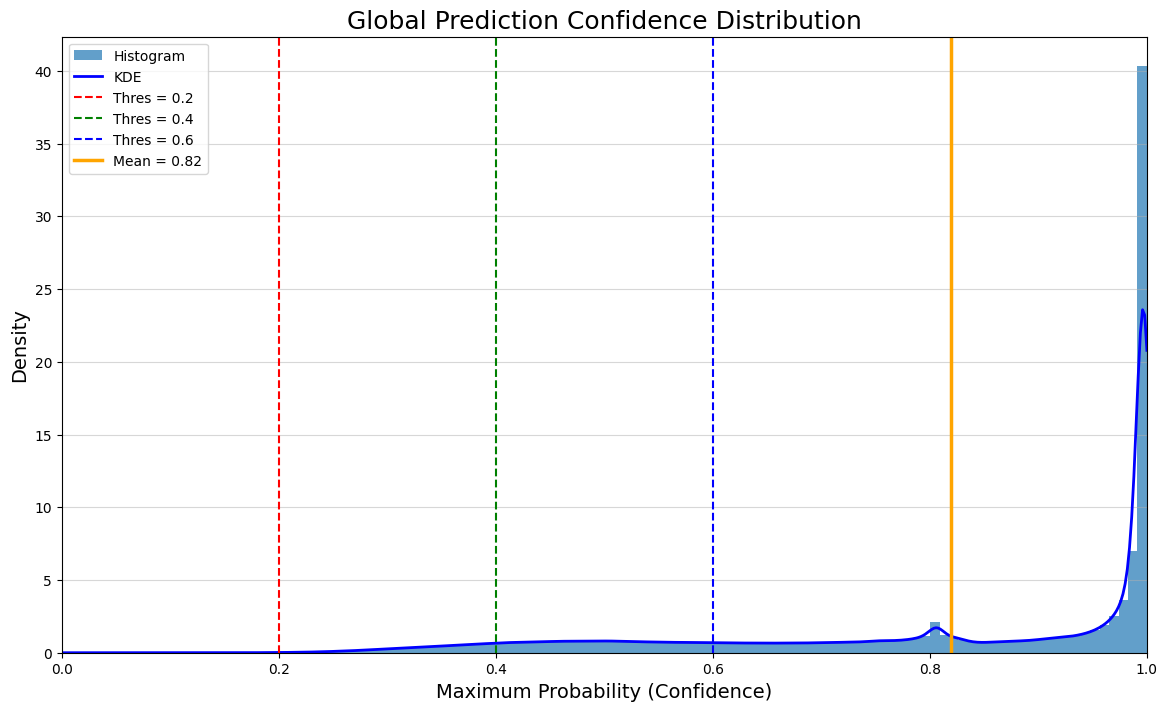

# 6. Visual Sanity Check: Plotting Sample Predictions
---
This helps to confirm that the entire pipeline is working as expected and that the model's outputs are qualitatively reasonable.

The function below, `plot_ensemble_predictions`, performs the following actions:
1.  Randomly selects a specified number of images from the inference directory.
2.  Runs the full, **3-model weighted ensemble** pipeline on each image, including TTA and confidence thresholding.
3.  Displays a side-by-side comparison of the original input image and the final predicted segmentation mask.

This provides an invaluable qualitative assessment of the model's performance on unseen data.

In [12]:
def plot_ensemble_predictions(
    models: list,
    model_weights: list,
    num_classes: int,
    inference_dir: str,
    num_samples: int = 3,
    device: str = 'cuda',
    use_tta: bool = True,
    confidence_thres: float = 0.0
) -> None:

    print(f"--- Plotting {num_samples} random sample predictions ---")
    all_image_paths = sorted(glob.glob(os.path.join(inference_dir, '*.png')))

    if len(all_image_paths) < num_samples:
        print(f"Warning: Requested {num_samples} samples, but only {len(all_image_paths)} images are available. Plotting all of them.")
        num_samples = len(all_image_paths)

    random_image_paths = random.sample(all_image_paths, num_samples)

    base_transform = A.Compose([A.Resize(640, 640), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()])

    for img_path in random_image_paths:
        print(f"\nProcessing: {Path(img_path).name}")
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        with torch.no_grad():
            if use_tta:
                flipped_image = cv2.flip(image, 1)
                original_tensor = base_transform(image=image)['image']
                flipped_tensor = base_transform(image=flipped_image)['image']
                input_batch = torch.stack([original_tensor, flipped_tensor]).to(device)
            else:
                input_batch = base_transform(image=image)['image'].unsqueeze(0).to(device)

            weighted_avg_probs = torch.zeros((input_batch.size(0), num_classes, 640, 640)).to(device)

            for model, weight in zip(models, model_weights):
                model.eval()
                outputs = model(input_batch)
                probs = torch.softmax(outputs, dim=1)
                weighted_avg_probs += weight * probs

            if use_tta:
                original_probs = weighted_avg_probs[0]
                flipped_probs = weighted_avg_probs[1]
                unflipped_probs = torch.flip(flipped_probs, dims=[-1])
                final_probs = (original_probs + unflipped_probs) / 2.0
            else:
                final_probs = weighted_avg_probs.squeeze(0)

            max_probs, pred_tensor = torch.max(final_probs, dim=0)
            if confidence_thres > 0:
                pred_base = pred_tensor.clone().cpu().numpy()
                pred_tensor[max_probs < confidence_thres] = 0

            pred = pred_tensor.cpu().numpy()

        plt.figure(figsize=(8, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f"Image: {Path(img_path).name}", fontsize=14)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(pred_base, cmap='nipy_spectral', vmin=0, vmax=num_classes-1)
        plt.title(f"Prediction (Thres: 0)", fontsize=14)
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred, cmap='nipy_spectral', vmin=0, vmax=num_classes-1)
        plt.title(f"Prediction (Thres: {confidence_thres})", fontsize=14)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

--- Plotting 3 random sample predictions ---

Processing: 000000001567.png


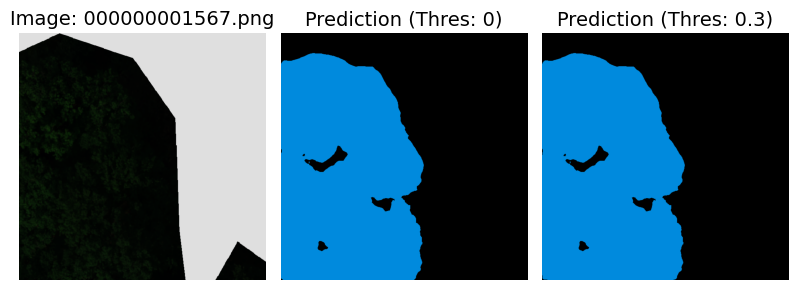


Processing: 000000002278.png


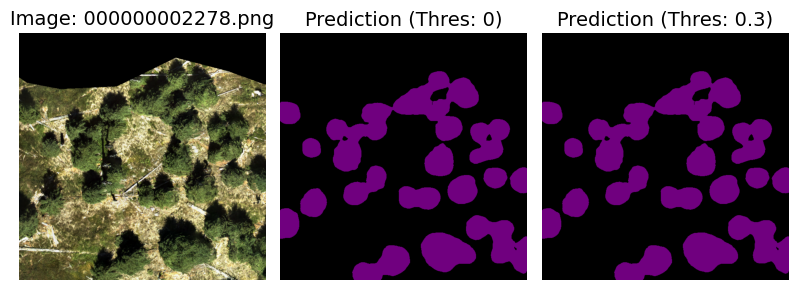


Processing: 000000001604.png


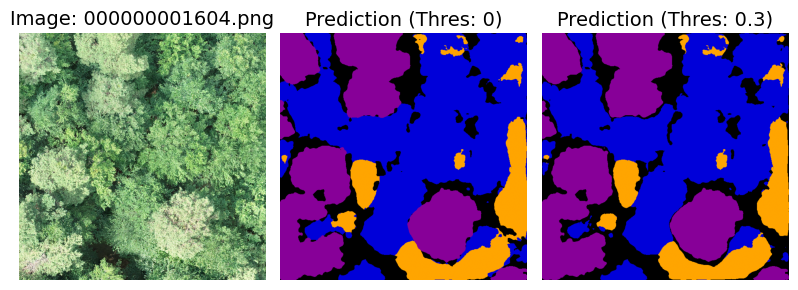

In [24]:
plot_ensemble_predictions(
    models=models_list,
    model_weights=weights_per_model,
    num_classes=num_classes,
    inference_dir=inference_dir,
    num_samples=3,
    device=device,
    use_tta=True,
    confidence_thres=0.3
)

# 7. Final Inference & Submission File Generation
---
This is the final and most important stage. The function `inference_with_ensemble` iterates through all images in the specified test directory and generates the final prediction files required for submission.

**The Pipeline:**
For each image, the function executes the complete, optimized inference strategy developed throughout this project:
1.  **Test-Time Augmentation (TTA):** The original image and its horizontally-flipped version are prepared.
2.  **Weighted Ensembling:** Both augmented views are passed through all four pre-trained models. The outputs (probabilities) are averaged using the pre-defined weights, which give a higher voice to the best-performing models.
3.  **TTA Averaging:** The predictions from the original and flipped views are combined to produce a more stable, robust probability map.
4.  **Confidence Thresholding:** A final confidence check is applied to filter out low-confidence predictions, effectively increasing the precision of the final mask by reducing false positives.
5.  **Saving:** The resulting segmentation mask is saved as a `.npy` file, following the format required by the competition.

In [17]:
def inference_with_ensemble(
    models: list,
    model_weights: list,
    num_classes: int,
    inference_dir: str,
    save_dir: str,
    device: str = 'cuda',
    use_tta: bool = True,
    confidence_thres: float = 0.0
) -> None:

    os.makedirs(save_dir, exist_ok=True)
    image_paths = sorted(glob.glob(os.path.join(inference_dir, '*.png')))
    base_transform = A.Compose([A.Resize(640, 640), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()])
    desc = f"Ensemble({len(models)}) + TTA + Thres({confidence_thres})"

    for img_path in tqdm(image_paths, desc=desc):
        image_name = Path(img_path).stem
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        with torch.no_grad():
            if use_tta:
                flipped_image = cv2.flip(image, 1)
                original_tensor = base_transform(image=image)['image']
                flipped_tensor = base_transform(image=flipped_image)['image']
                input_batch = torch.stack([original_tensor, flipped_tensor]).to(device)
            else:
                input_batch = base_transform(image=image)['image'].unsqueeze(0).to(device)

            weighted_avg_probs = torch.zeros((input_batch.size(0), num_classes, 640, 640)).to(device)

            for model, weight in zip(models, model_weights):
                model.eval()
                outputs = model(input_batch)
                probs = torch.softmax(outputs, dim=1)
                weighted_avg_probs += weight * probs

            if use_tta:
                original_probs = weighted_avg_probs[0]
                flipped_probs = weighted_avg_probs[1]
                unflipped_probs = torch.flip(flipped_probs, dims=[-1])
                final_probs = (original_probs + unflipped_probs) / 2.0
            else:
                final_probs = weighted_avg_probs.squeeze(0)

            max_probs, pred_tensor = torch.max(final_probs, dim=0)
            if confidence_thres > 0:
                pred_tensor[max_probs < confidence_thres] = 0

            pred = pred_tensor.cpu().numpy()

        filename = f"{image_name}.npy"
        save_path = os.path.join(save_dir, filename)
        np.save(save_path, pred)

In [29]:
inference_with_ensemble(
    models=models_list,
    model_weights=weights_per_model,
    num_classes=num_classes,
    inference_dir=inference_dir,
    save_dir=save_dir,
    device=device,
    use_tta=True,
    confidence_thres=0.3
)

Ensemble(4) + TTA + Thres(0.3): 100%|██████████| 159/159 [02:26<00:00,  1.09it/s]
